In [1]:
# Normal imports for everybody
import keras
#from context import * # imports the MDN layer 
import mdn
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import time

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
t=time.time()
X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')
print(time.time()-t)
print(np.shape(X),np.shape(Y))

143.0171127319336
(24571, 5000) (24571, 500)


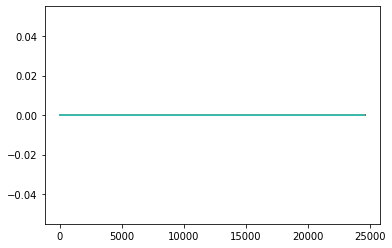

[-0.82188075  3.35414138  0.77480965 -0.57932854] [0.17953081 0.08178025 0.12285084 0.04704531]


In [3]:
X=np.reshape(X,(-1,1000,5))

plt.plot(X[:,:,4])
plt.show()
X=X[:,:,:4]

eps=1e-15

X=X*(X>0)
X=np.log10(X+eps)

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
print(x_mean,x_std)
for i in range(4):
    X[:,:,i]=(X[:,:,i]-x_mean[i])/x_std[i]

X=np.reshape(X,(-1,1000*4))
    
Y=np.log10(Y*1e20)

#Min_Max Scaling of Y
y_min=np.min(Y)
Y=Y-y_min
y_max=np.max(Y)
Y=Y/y_max

In [4]:
x_data=X
y_data=Y

In [5]:
N_INPUT=4*1000
N_MIXES = 10
N_OUTPUT = 500

model = keras.Sequential()
model.add(keras.layers.Dense(2000, batch_input_shape=(None, N_INPUT), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4000, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2000, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4000, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(mdn.MDN(N_OUTPUT, N_MIXES)) #output dimensions, no. of mixes.
model.compile(loss=mdn.get_mixture_loss_func(N_OUTPUT,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000)              8000      
_________________________________________________________________
dense_2 (Dense)              (None, 4000)              8004000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4000)              16000     
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
batch_normalization_3 (Batch (None, 2000)              8000      
_________________________________________________________________
dens

In [6]:
history = model.fit(x=x_data, y=y_data, batch_size=2048, epochs=40, validation_split=0.15,callbacks=[keras.callbacks.TerminateOnNaN()])

Instructions for updating:
Use tf.cast instead.
Train on 20885 samples, validate on 3686 samples
Epoch 1/40
20885/20885 [==============================] - 61s 3ms/step - loss: 1469337333.3653 - val_loss: 22216761086229.8086
Epoch 2/40
20885/20885 [==============================] - 47s 2ms/step - loss: -35.5082 - val_loss: 4595.7539
Epoch 3/40
20885/20885 [==============================] - 50s 2ms/step - loss: -207.8969 - val_loss: 517.9042
Epoch 4/40
20885/20885 [==============================] - 52s 2ms/step - loss: -236.5938 - val_loss: 342.8776
Epoch 5/40
20885/20885 [==============================] - 52s 2ms/step - loss: -221.2869 - val_loss: 205.4391
Epoch 6/40
20885/20885 [==============================] - 49s 2ms/step - loss: -197.1473 - val_loss: 95.2409
Epoch 7/40
20885/20885 [==============================] - 50s 2ms/step - loss: -169.5664 - val_loss: 96.7660
Epoch 8/40
20885/20885 [==============================] - 49s 2ms/step - loss: -168.1765 - val_loss: 20.9007
Epoch 9/4

In [7]:
print(np.shape(y_test),np.shape(y_data))

NameError: name 'y_test' is not defined

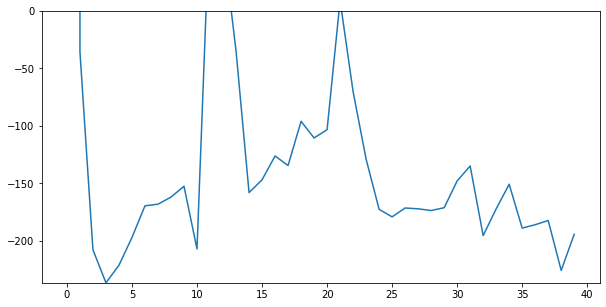

In [35]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.ylim([np.min(history.history['loss']),0])
#plt.plot(history.history['val_loss'])
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

The `mdn` module provides a function to sample from these parameters as follows. First the parameters are split up into `mu`s, `sigma`s and `pi`s, then the categorical distribution formed by the `pi`s is sampled to choose which mixture component should be sampled, then that component's `mu`s and `sigma`s is used to sample from a multivariate normal model, here's the code:

    def sample_from_output(params, output_dim, num_mixes, temp=1.0):
        """Sample from an MDN output with temperature adjustment."""
        mus = params[:num_mixes*output_dim]
        sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
        pis = softmax(params[-num_mixes:], t=temp)
        m = sample_from_categorical(pis)
        # Alternative way to sample from categorical:
        # m = np.random.choice(range(len(pis)), p=pis)
        mus_vector = mus[m*output_dim:(m+1)*output_dim]
        sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
        cov_matrix = np.identity(output_dim) * sig_vector
        sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
        return sample
        
If you only have one prediction to sample from, you can use the function as is; but if you need to sample from a lot of predictions at once (as in the following sections), you can use `np.apply_along_axis` to apply it to a whole numpy array of predicted parameters.

In [9]:
y_test = model.predict(x_data)

In [10]:
import scipy.ndimage.filters as sp
from scipy.special import softmax
import importlib
import bolsig
importlib.reload(bolsig)
from bolsig import bolsig

In [26]:
n=100

y=np.arange(0,1,0.002)
y_hat=np.zeros((n,500))
pdf=np.zeros((n,len(y),N_OUTPUT)) #Heat map data of PDF

for i in range(n):
    #plt.plot(gaussian_filter1d(y_test[i,:500],40))
    x=range(N_OUTPUT)    
    pis=softmax(y_test[i,-N_MIXES:])
    argmax=np.argmax(pis)
    for j in range(N_MIXES):
        mus=y_test[i,j*N_OUTPUT:N_OUTPUT*(j+1)]
        sigs=y_test[i,N_OUTPUT*(N_MIXES+j):N_OUTPUT*(N_MIXES+j+1)]
        #y_hat[i,:]+=mus*pis[j] #Mean
        if j==argmax:
            y_hat[i,:]=mus #Mode
        for k in range(N_OUTPUT):
            #plt.plot(sp.gaussian_filter1d(mus,50),'g-',label='Predicted')
            pdf[i,:,k]+=pis[j]*np.exp(-(y-mus[k])**2/sigs[k]**2/2)/np.sqrt(2*np.pi)/sigs[k]
    pdf[i,:,:]=sp.gaussian_filter(pdf[i,:,:],20)
    pdf[i,:,:]=np.flipud(pdf[i,:,:])
    y_hat[i,:]=sp.gaussian_filter1d(y_hat[i,:],40)
    '''
    plt.plot(y_data[i,:],label='True')
    plt.plot(y_hat[i,:],label='Predicted')
    plt.ylim((0,1))
    plt.legend()
    plt.show()
    '''
    '''
    f=plt.figure(figsize=(10,5))
    ax1 = f.add_subplot(1,2,1, aspect=1)
    ax2 = f.add_subplot(1,2,2)
    
    ax1.imshow(pdf[i,:,:])
    ax2.plot(y_data[i,:])
    plt.ylim((0,1))
    '''

|(1000, 4)


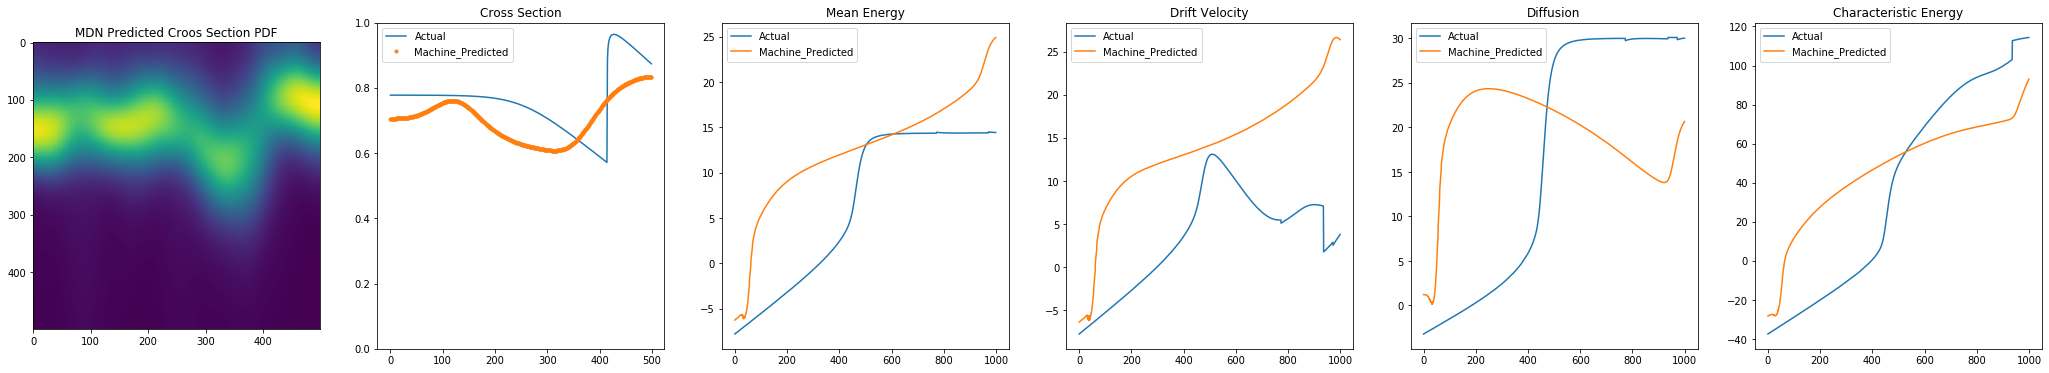

2.6094844341278076


In [28]:
#Inverting normalisation of Predicted Y
y_pred=10**((y_hat*y_max)+y_min)*1e-20

E=np.logspace(-3,3,500)

t=time.time()
for i in range(42,43):
    #plt.loglog(E,y_hat[i,:])
    bolsig.Input(E,y_pred[i,:])
    bolsig.ex(grid=100,n=1000) #n cannot be more than 1000
    bolsig.Bolsig()
    trans=bolsig.Output(n=1000)
    print('|',end='')
    if np.sum(trans<0)>0:
        plt.loglog(E,Y[i,:]*1e20)
        plt.show()
        continue
    print(np.shape(trans))
    trans=np.log10(trans)
    #Normalisation trans to match X
    trans=np.reshape(trans,(-1,1000,4))
    for j in range(4):
        trans[:,:,j]=(trans[:,:,j]-x_mean[j])/x_std[j]
    
    fig, ax = plt.subplots(1, 6, figsize=(36,6))
    title=['MDN Predicted Croos Section PDF','Cross Section','Mean Energy',
           'Drift Velocity','Diffusion','Characteristic Energy']
    ax[0].imshow(pdf[i,:,:])
    ax[0].set_title(title[0])
    ax[1].plot(Y[i,:])
    ax[1].plot(y_hat[i,:],'.')
    ax[1].legend(['Actual','Machine_Predicted'])
    ax[1].set_title(title[1])
    ax[1].set_ylim((0,1))
    for j in range(4):
        ax[j+2].plot(np.reshape(X[i,:],(1000,4))[:,j])
        ax[j+2].plot(trans[0,:,j])
        ax[j+2].legend(['Actual','Machine_Predicted'])
        ax[j+2].set_title(title[j+2])
    plt.savefig(str(i)+'.png')
    plt.show()
print(time.time()-t)

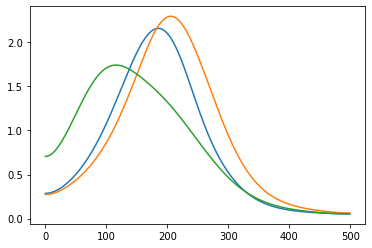

In [33]:
plt.plot(pdf[i,:,300])
plt.plot(pdf[i,:,350])
plt.plot(pdf[i,:,400])

In [ ]:
y=np.arange(-100,100,0.4)

for i in range(88,90):
    #plt.plot(gaussian_filter1d(y_test[i,:500],40))
    x=range(N_OUTPUT)    
    pis=softmax(y_test[i,-N_MIXES:])
    
    for j in range(N_MIXES):
        mus=y_test[i,j*N_OUTPUT:N_OUTPUT*(j+1)]
        sigs=y_test[i,N_OUTPUT*(N_MIXES+j):N_OUTPUT*(N_MIXES+j+1)]
        plt.plot(np.sort(sigs))
        y_hat[i,:]+=mus*pis[j]
        for k in range(N_OUTPUT):
            #plt.plot(sp.gaussian_filter1d(mus,50),'g-',label='Predicted')
            pdf[i,:,k]+=pis[j]*np.exp(-(y-mus[k])**2/sigs[k]**2/2)/np.sqrt(2*np.pi)/sigs[k]
    plt.show()
    pdf[i,:,:]=sp.gaussian_filter(pdf[i,:,:],20)
    pdf[i,:,:]=np.flipud(pdf[i,:,:])
    y_hat[i,:]=sp.gaussian_filter1d(y_hat[i,:],20)

    plt.plot(y_data[i,:],label='True')
    plt.plot(y_hat[i,:],label='Predicted')
    plt.ylim((-100,100))
    plt.legend()
    plt.show()

    f=plt.figure(figsize=(10,5))
    ax1 = f.add_subplot(1,2,1, aspect=1)
    ax2 = f.add_subplot(1,2,2)
    
    ax1.imshow(pdf[i,:,:])
    ax2.plot(y_data[i,:])
    plt.ylim((0,1))


In [ ]:
ar_Y=np.loadtxt('Ar_Y.csv',delimiter=',')

ar_E=ar_Y[:,0]
ar_Y=ar_Y[:,1]*1e-20

bolsig.Input(ar_E,ar_Y,n=len(ar_E))
bolsig.ex(grid=100,n=1000) #n cannot be more than 1000
bolsig.Bolsig()
ar_X=bolsig.Output(n=1000)

ar_X=np.reshape(ar_X,(-1,1000,4))
eps=1e-15

ar_X=ar_X*(ar_X>0)
ar_X=np.log10(ar_X+eps)

for i in range(4):
    print(x_mean[i],x_std[i])
    ar_X[0,:,i]=(ar_X[0,:,i]-x_mean[i])/x_std[i]

plt.plot(np.reshape(ar_X,(1000,4)))
plt.show()

ar_X=np.reshape(ar_X,(1,1000*4))

ar_Y=np.log10(ar_Y*1e20)

#Min_Max Scaling of Y
ar_Y=ar_Y-y_min
ar_Y=ar_Y/y_max

y_test = model.predict(ar_X)

plt.semilogx(ar_E,ar_Y)
plt.show()

In [ ]:

n=1

y=np.arange(0,1,0.002)
y_hat=np.zeros((n,500))
pdf=np.zeros((n,len(y),N_OUTPUT)) #Heat map data of PDF

for i in range(n):
    #plt.plot(gaussian_filter1d(y_test[i,:500],40))
    x=range(N_OUTPUT)    
    pis=softmax(y_test[i,-N_MIXES:])
    
    for j in range(N_MIXES):
        mus=y_test[i,j*N_OUTPUT:N_OUTPUT*(j+1)]
        sigs=y_test[i,N_OUTPUT*(N_MIXES+j):N_OUTPUT*(N_MIXES+j+1)]
        y_hat[i,:]+=mus*pis[j]
        for k in range(N_OUTPUT):
            #plt.plot(sp.gaussian_filter1d(mus,50),'g-',label='Predicted')
            pdf[i,:,k]+=pis[j]*np.exp(-(y-mus[k])**2/sigs[k]**2/2)/np.sqrt(2*np.pi)/sigs[k]
    pdf[i,:,:]=sp.gaussian_filter(pdf[i,:,:],20)
    pdf[i,:,:]=np.flipud(pdf[i,:,:])
    y_hat[i,:]=sp.gaussian_filter1d(y_hat[i,:],20)
    '''
    plt.plot(y_data[i,:],label='True')
    plt.plot(y_hat[i,:],label='Predicted')
    plt.ylim((0,1))
    plt.legend()
    plt.show()
    '''
    '''
    f=plt.figure(figsize=(10,5))
    ax1 = f.add_subplot(1,2,1, aspect=1)
    ax2 = f.add_subplot(1,2,2)
    
    ax1.imshow(pdf[i,:,:])
    ax2.plot(y_data[i,:])
    plt.ylim((0,1))
    '''

#Inverting normalisation of Predicted Y
y_pred=10**((y_hat*y_max)+y_min)*1e-20

E=np.logspace(-3,3,500)

t=time.time()
for i in range(n):
    #plt.loglog(E,y_hat[i,:])
    bolsig.Input(E,y_pred[i,:])
    bolsig.ex(grid=100,n=1000) #n cannot be more than 1000
    bolsig.Bolsig()
    trans=bolsig.Output(n=1000)
    print('|',end='')
    if np.sum(trans<0)>0:
        plt.loglog(E,Y[i,:]*1e20)
        plt.show()
        continue
    print(np.shape(trans))
    trans=np.log10(trans)
    #Normalisation trans to match X
    trans=np.reshape(trans,(-1,1000,4))
    for j in range(4):
        trans[:,:,j]=(trans[:,:,j]-x_mean[j])/x_std[j]
    
    fig, ax = plt.subplots(1, 6, figsize=(36,6))
    title=['MDN Predicted Croos Section PDF','Cross Section','Mean Energy',
           'Drift Velocity','Diffusion','Characteristic Energy']
    ax[0].imshow(pdf[i,:,:])
    ax[0].set_title(title[0])
    ax[1].semilogx(ar_E,ar_Y)
    ax[1].semilogx(E,y_hat[i,:],'.')
    ax[1].legend(['Actual','Machine_Predicted'])
    ax[1].set_title(title[1])
    ax[1].set_ylim((0,1))
    for j in range(4):
        ax[j+2].plot(np.reshape(ar_X[i,:],(1000,4))[:,j])
        ax[j+2].plot(trans[0,:,j])
        ax[j+2].legend(['Actual','Machine_Predicted'])
        ax[j+2].set_title(title[j+2])
    plt.savefig(str(i)+'.png')
    plt.show()
print(time.time()-t)

In [ ]:
np.shape(ar_X)